In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2001(2) 统计分析

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_012(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata012 = pd.read_csv("perlist012_h.csv")
    f = perdata012['f']
    per = perdata012['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata012)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m012=Minuit(twi_minus_loglikelihood_012,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=1,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.01,error_poisson=0.01,
         limit_log_A=(-5,0), limit_log_f_b=(-7,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,5),
         errordef=1)

m012.migrad()

pprint(m012.fval)

FCN = 3038.056298109863 
 TOTAL NCALL = 664 
 NCALLS = 664 
 
 
 EDM = 0.00019309441128281362 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-0.0772831,4.01536,,,-5,0,No
1,log_f_b,-6.26158,0.939983,,,-7,-2,No
2,alpha_H,2.64403,0.732232,,,1,5,No
3,poisson,2.4014,0.0871928,,,0,5,No


3038.056298109863


In [4]:
perdata012 = pd.read_csv("perlist012_h.csv")
f_012 = perdata012['f']
per_012 = perdata012['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m012.values[0],m012.values[1],m012.values[2],m012.values[3]

model_012 = []
R_obs_012 = []
T_SSE_obs_012 = 0
f_length_012 = len(f_012)
for i in range(f_length_012):
    model_012.append(((f_012[i]**(-alpha_L))/(1+(f_012[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_012.append(2*per_012[i]/model_012[i])
    T_SSE_obs_012 += (((per_012[i]-model_012[i])/model_012[i])**2)
    
# 两个统计量
T_R_obs_012 = max(R_obs_012)
print ("T_R =", T_R_obs_012)
print ("T_SSE =", T_SSE_obs_012)

T_R = 13.758550905165047
T_SSE = 773.6837785944125


In [5]:
# 5000条光变曲线

df = 0.01/f_length_012
N = 2*f_length_012
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_012]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_012):
        R_simu.append(2*per_simu[i]/model_012[i])
        T_SSE_simu += (((per_simu[i]-model_012[i])/model_012[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_012:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_012:
        n_TSSE += 1

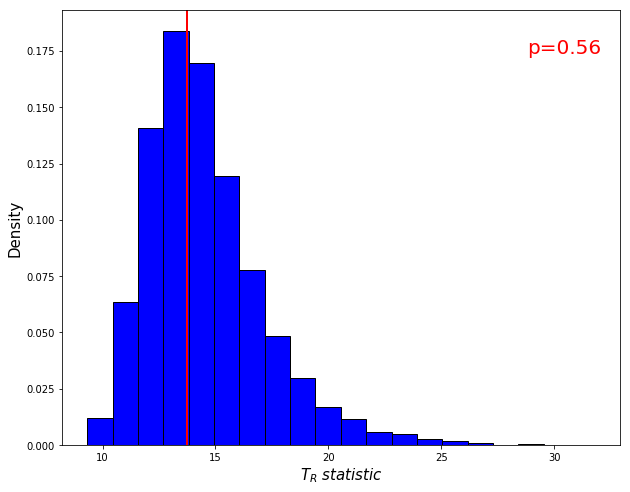

In [6]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_012, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

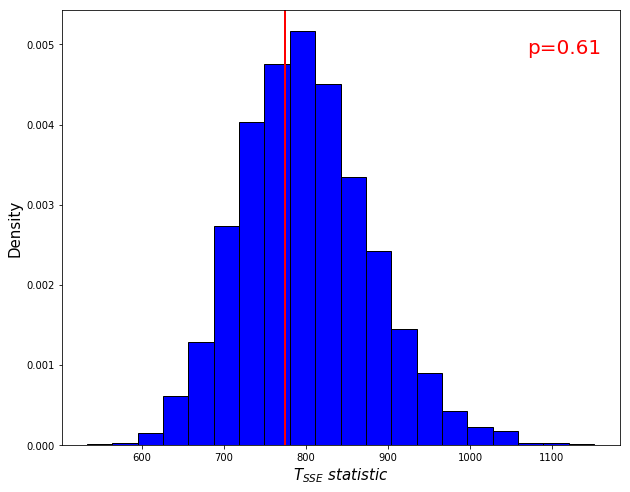

In [7]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_012, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2006(3) 统计分析

In [8]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_063(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata063 = pd.read_csv("perlist063_h.csv")
    f = perdata063['f']
    per = perdata063['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata063)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [9]:
m063=Minuit(twi_minus_loglikelihood_063,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.01,error_poisson=0.01,
         limit_log_A=(-3,0), limit_log_f_b=(-7,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

m063.migrad()

pprint(m063.fval)

FCN = 995.9431418126874 
 TOTAL NCALL = 409 
 NCALLS = 409 
 
 
 EDM = 0.0001325966262848017 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-0.0228057,2.49236,,,-3,0,No
1,log_f_b,-6.17749,0.613286,,,-7,-2,No
2,alpha_H,2.12957,0.206646,,,1,5,No
3,poisson,0.84377,0.0428664,,,0,2,No


995.9431418126874


In [10]:
perdata063 = pd.read_csv("perlist063_h.csv")
f_063 = perdata063['f']
per_063 = perdata063['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m063.values[0],m063.values[1],m063.values[2],m063.values[3]

model_063 = []
R_obs_063 = []
T_SSE_obs_063 = 0
f_length_063 = len(f_063)
for i in range(f_length_063):
    model_063.append(((f_063[i]**(-alpha_L))/(1+(f_063[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_063.append(2*per_063[i]/model_063[i])
    T_SSE_obs_063 += (((per_063[i]-model_063[i])/model_063[i])**2)
    
# 两个统计量
T_R_obs_063 = max(R_obs_063)
print ("T_R =", T_R_obs_063)
print ("T_SSE =", T_SSE_obs_063)

T_R = 9.963108746629233
T_SSE = 435.6950085069298


In [11]:
# 5000条光变曲线

df = 0.01/f_length_063
N = 2*f_length_063
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_063]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_063):
        R_simu.append(2*per_simu[i]/model_063[i])
        T_SSE_simu += (((per_simu[i]-model_063[i])/model_063[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_063:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_063:
        n_TSSE += 1

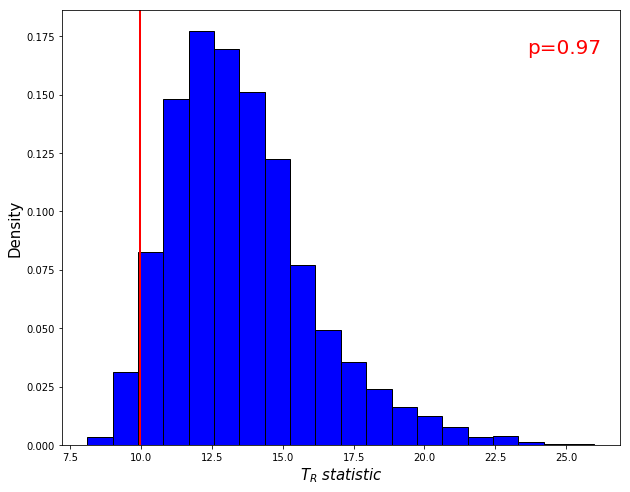

In [12]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_063, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

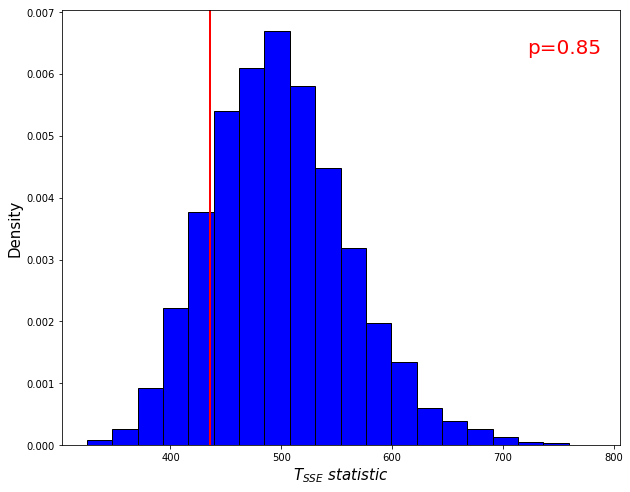

In [13]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_063, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 综合结果

In [8]:
data012 = pd.read_csv("energy_ngc3516_012.csv")  
x012 = data012['x']
y012 = data012['y']
xerr012 = data012['xerr']
yerr012 = data012['yerr']

data063 = pd.read_csv("energy_ngc3516_063.csv")  
x063 = data063['x']
y063 = data063['y']
xerr063 = data063['xerr']
yerr063 = data063['yerr']

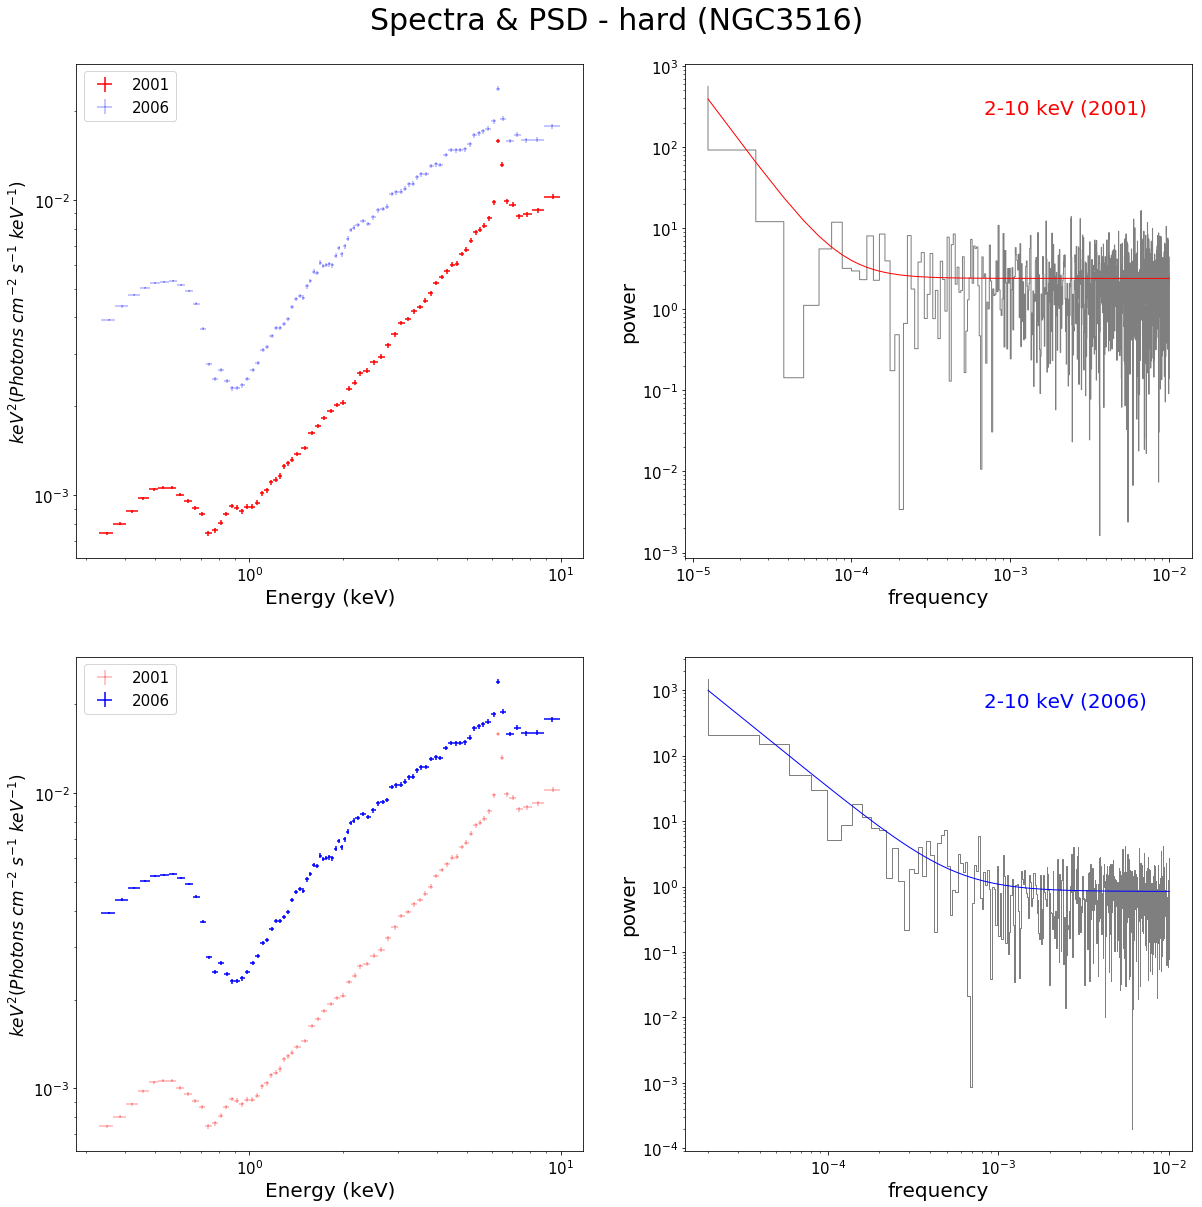

In [9]:
fig= plt.figure(figsize=(20,20))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)


ax1.loglog()
ax1.errorbar(x012, y012, yerr=yerr012, xerr=xerr012, fmt=',r', label='2001')
ax1.errorbar(x063, y063, yerr=yerr063, xerr=xerr063, fmt=',b', alpha=0.3, label='2006')
ax1.set_xlabel("Energy (keV)",fontsize=20)
ax1.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)

ax3.loglog()
ax3.errorbar(x012, y012, yerr=yerr012, xerr=xerr012, fmt=',r', alpha=0.3, label='2001')
ax3.errorbar(x063, y063, yerr=yerr063, xerr=xerr063, fmt=',b', label='2006')
ax3.set_xlabel("Energy (keV)",fontsize=20)
ax3.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax3.legend(fontsize=15)
ax3.tick_params(labelsize=15)


ax2.loglog()
ax2.step(f_012, per_012, color="k", alpha=0.5, linewidth=1)
ax2.plot(f_012, model_012, color="r", linewidth=1)
ax2.set_xlabel("frequency",fontsize=20)
ax2.set_ylabel("power",fontsize=20)
ax2.text(0.75,0.9,"2-10 keV (2001)",color='r',ha='center',transform=ax2.transAxes,fontsize=20)
ax2.tick_params(labelsize=15)

ax4.loglog()
ax4.step(f_063, per_063, color="k", alpha=0.5, linewidth=1)
ax4.plot(f_063, model_063, color="b", linewidth=1)
ax4.set_xlabel("frequency",fontsize=20)
ax4.set_ylabel("power",fontsize=20)
ax4.text(0.75,-0.3,"2-10 keV (2006)",color='b',ha='center',transform=ax2.transAxes,fontsize=20)
ax4.tick_params(labelsize=15)


plt.suptitle("Spectra & PSD - hard (NGC3516)", x=0.5, y=0.92, fontsize=30)
plt.show()

## 2001(2) MCMC

In [10]:
# 均匀先验

def lnprior_012(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -8 < log_A < 25 and -15 < log_f_b < -2 and 1.0 < alpha_H < 20.0 and 0.0 < poisson < 5.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_012(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_012(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_012(log_A,log_f_b,alpha_H,poisson))

In [11]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m012.values[0],m012.values[1],m012.values[2],m012.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_012)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1163.6 seconds


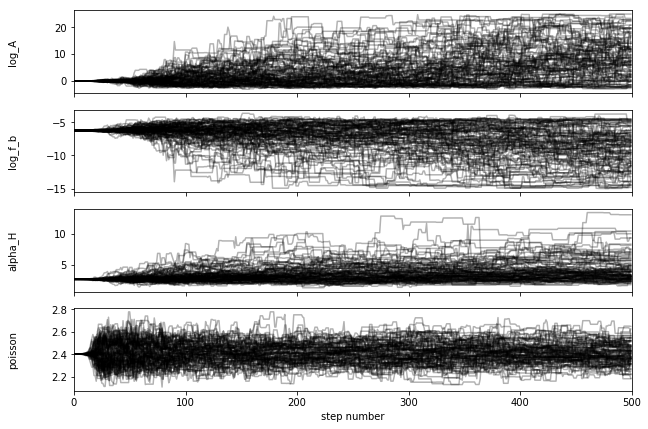

In [12]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [13]:
print ("Parameters (2001)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2001)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

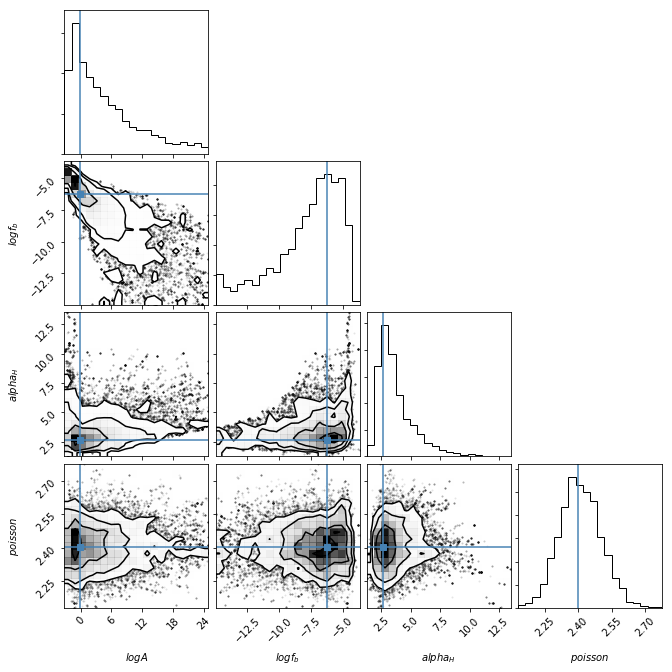

In [14]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m012.values[0], m012.values[1], m012.values[2], m012.values[3]])

## 2006(3) MCMC

In [15]:
# 均匀先验

def lnprior_063(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -5 < log_A < 10 and -20 < log_f_b < -2 and 1.0 < alpha_H < 10.0 and 0.0 < poisson < 3.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_063(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_063(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_063(log_A,log_f_b,alpha_H,poisson))

In [16]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m063.values[0],m063.values[1],m063.values[2],m063.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_063)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 732.0 seconds


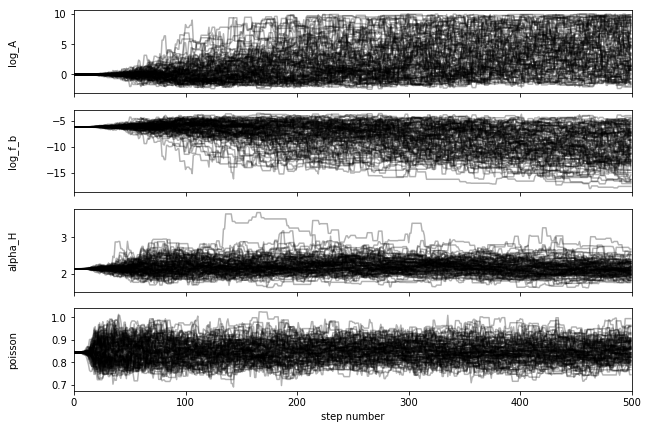

In [17]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [18]:
print ("Parameters (2006)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2006)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

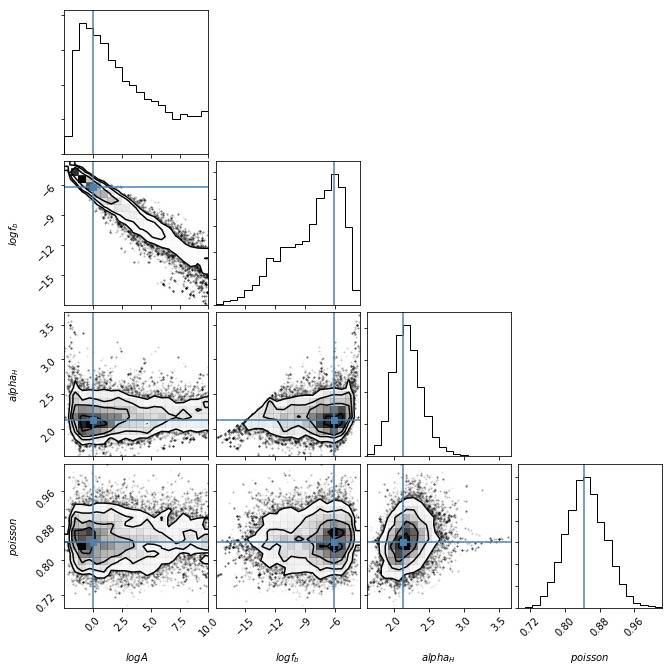

In [19]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m063.values[0], m063.values[1], m063.values[2], m063.values[3]])